# Optimisation Experiment with Optuna

## 1. Import Libraries

In [128]:
from __future__ import print_function
%matplotlib inline
import argparse #generates help messages
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel # implements data parallelism across multiple devices/GPUs
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torch.optim as optim # optimizer for example optim.Adam([var1, var2], lr=0.0001)
import torch.utils.data # for the dataloader class (python iterable over a dataset)
import torchvision.datasets as dset # all datasets available in torch vision. not sure if needed here
import torchvision.transforms as transforms # all transformations for data augmentation (pad, resize, centercrop, ...)
import torchvision.utils as vutils # draw bounding box, segmantation mask, keypoints. convert to rgb, make grid, save_image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import optuna
from optuna.trial import TrialState
import logging
from IPython.display import HTML # to embed html in the Ipython output
import datetime
import mlflow

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

%load_ext autoreload
%autoreload 2

Random Seed:  999
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [129]:
logging.basicConfig(level=logging.DEBUG, filename='../reports/02OEwO.log')

## 2. Set the Parameters

In [267]:
dataroot = "../../png/train" # Root directory for train dataset
datarootTest = "../../png/test" # Root directory for dataset
workers = 2 # Number of workers for dataloader
batch_size = 64 # Batch size during training
image_size = 64 # Spatial size of training images. All images will be resized to this
nc = 3 # Number of channels in the training images. For color images this is 3
nz = 100 # Size of z latent vector (i.e. size of generator input)
ngf = 64 # Size of feature maps in generator
ndf = 64 # Size of feature maps in discriminator
num_epochs = 50 # Number of training epochs
lr = 0.0002 # Learning rate for optimizers
beta1 = 0.5 # Beta1 hyperparam for Adam optimizers
ngpu = torch.cuda.device_count() # Number of GPUs available. Use 0 for CPU mode.

In [131]:
# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [270]:
import os
print(len([entry for entry in os.listdir(dataroot) if os.path.isfile(os.path.join(dataroot, entry))]))

103


## 3. Create Dataloader

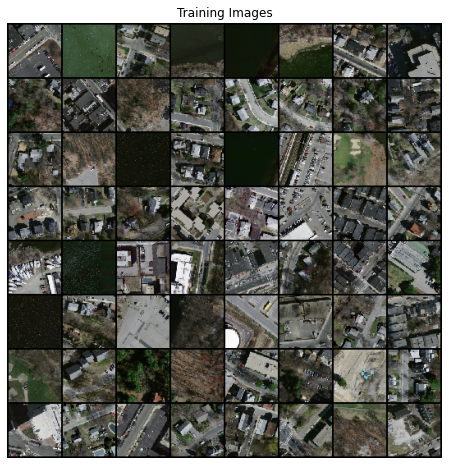

In [268]:
# We can use an image folder dataset the way we have it setup.
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               #transforms.Resize(image_size),
                               transforms.RandomCrop(image_size),
                               #transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)));

In [269]:
len(real_batch[0])

64

In [133]:
datasetTest = dset.ImageFolder(root=datarootTest,
                               transform=transforms.Compose([
                               #transforms.Resize(image_size),
                               transforms.RandomCrop(image_size),
                               #transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloaderTest = torch.utils.data.DataLoader(datasetTest, batch_size=batch_size,
                                             shuffle=True, num_workers=workers)

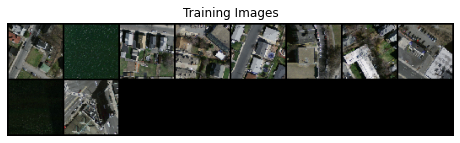

In [134]:
test_batch = next(iter(dataloaderTest))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(test_batch[0].to(device)[:10], padding=2, normalize=True).cpu(),(1,2,0)));

## 4. Weight Initialization

In [135]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02) # fills the weights? gamma param with normal distribution
        nn.init.constant_(m.bias.data, 0) # fills the bias with the constant 0

# 5. Generator Class

In [14]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution with dimensions c=nz, h=1, w=1
            nn.ConvTranspose2d(in_channels=nz, #deconvolution!
                               out_channels=ngf * 8, 
                               kernel_size=4, 
                               stride=1, 
                               padding=0, 
                               bias=False), #no learnable bias 
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels=ngf * 8, 
                               out_channels=ngf * 4, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.BatchNorm2d(ngf * 4), # accelerates the learning rate by 14 times
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels=ngf * 4, 
                               out_channels=ngf * 2, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels=ngf * 2, 
                               out_channels=ngf, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels=ngf, 
                               out_channels=nc, 
                               kernel_size=4, 
                               stride=2, 
                               padding=1, 
                               bias=False),
            nn.Sigmoid() # since the desired output is in range of -1 and +1 (impossible with ReLU and sigmoid D[0,1])
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [15]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(module=netG, devide_ids=list(range(ngpu))) # recommended to use DistributedDataParallel instead

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [243]:
t = [1,2,4,5,6]
t.reverse()
t

[6, 5, 4, 2, 1]

In [257]:
class OptGen(nn.Module):
    def __init__(self, ngpu, num_conv_layers):
        super(OptGen, self).__init__()
        self.ngpu = ngpu
        self.num_filters = [3] 
        self.num_filters.extend([2**(i+6) for i in range(num_conv_layers-1)])
        self.strides = [2]
        self.paddings = [1]
        self.kernelSizes = [4]
        self.out_size = []
        if num_conv_layers == 3:
            self.strides.extend([2,2])
            self.paddings.extend([0,0])
            self.kernelSizes.extend([14,10])
        if num_conv_layers == 4:
            self.strides.extend([2,2,2])
            self.paddings.extend([1,0,0])
            self.kernelSizes.extend([4,6,6])
        if num_conv_layers == 5:
            self.strides.extend([2,2,2,2])
            self.paddings.extend([1,1,1,0])
            self.kernelSizes.extend([4,4,4,4])
        if num_conv_layers == 6:
            self.strides.extend([2,2,2,2,2])
            self.paddings.extend([1,1,1,1,1])
            self.kernelSizes.extend([4,4,4,4,4])
        # self.out_size = []
        # same scheme as for DNet, but inverted
        self.num_filters.reverse()
        self.strides.reverse()
        self.paddings.reverse()
        self.kernelSizes.reverse()
        
        self.main = nn.Sequential(
            # input is Z, going into a convolution with dimensions c=nz, h=1, w=1
            # output size: (2**6) x 4 x 4 O=(I-1)*s+k-2p
            nn.ConvTranspose2d(in_channels=nz, #deconvolution!
                               out_channels=self.num_filters[0], #ngf * 8, 
                               kernel_size=self.kernelSizes[0], 
                               stride=self.strides[0], 
                               padding=self.paddings[0], 
                               bias=False), # (1-1)*1+4-2*0=4
            nn.BatchNorm2d(self.num_filters[0]),
            nn.ReLU(True)
        )
        self.out_size.append([self.num_filters[0], (1-1)*self.strides[0]+self.kernelSizes[0]-2*self.paddings[0]])
        self.num_modules = 3
        for i in range(1, num_conv_layers):
            self.main.add_module(str(3*i-1)+"): TransConv_"+str(i+1), nn.ConvTranspose2d(in_channels=self.num_filters[i-1],
                                                            out_channels=self.num_filters[i],
                                                            kernel_size=self.kernelSizes[i],
                                                            stride=self.strides[i],
                                                            padding=self.paddings[i],
                                                            bias=False))
            self.out_size.append([self.num_filters[i], (self.out_size[i-1][1]-1)*self.strides[i]+self.kernelSizes[i]-2*self.paddings[i]])
            self.num_modules += 1
            if i + 1 < num_conv_layers: 
                self.main.add_module(str(3*i)+"): BatchNorm_" + str(i+1), nn.BatchNorm2d(self.num_filters[i]))
                self.main.add_module(str(1+3*i)+"): ReLU_" + str(i+1), nn.ReLU(True))
                self.num_modules += 2
            
        self.main.add_module(str(self.num_modules), nn.Sigmoid())
        print(f"Progression of the sizes in the deconvolution: {self.out_size}")
    
    def forward(self, input):
        return self.main(input)

In [250]:
testGen = OptGen(1, 6).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    testGen = nn.DataParallel(testGen, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
testGen.apply(weights_init)

print(testGen)

Progression of the sizes in the deconvolution: [[1, 2], [1024, 4], [512, 8], [256, 16], [128, 32], [64, 64]]
OptGen(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (2): TransConv_2): ConvTranspose2d(1, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm_2): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReLU_2): ReLU(inplace=True)
    (5): TransConv_3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm_3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU_3): ReLU(inplace=True)
    (8): TransConv_4): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm_4): BatchNo

# 6. Discriminator

In [53]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(in_channels=nc, 
                      out_channels=ndf, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), # (64-4+2)/2 + 1=32
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(in_channels=ndf, 
                      out_channels=ndf * 2, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), # (32-4+2)/2+1=16
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(in_channels=ndf * 2, 
                      out_channels=ndf * 4, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), #(16-4+2)/2+1=8
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(in_channels=ndf * 4, 
                      out_channels=ndf * 8, 
                      kernel_size=4, 
                      stride=2, 
                      padding=1, 
                      bias=False), #(8-4+2)/2+1=4
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(in_channels=ndf * 8, 
                      out_channels=1, 
                      kernel_size=4, 
                      stride=1, 
                      padding=0, 
                      bias=False), #(4-4)/2+1=1
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [150]:
### num_conv_layers = 6 # till 6
### num_filters = [2**(i+6) for i in range(num_conv_layers-1)]
### num_filters.append(1)
### in_size = 64
### kernel_size = 4
### paddings = [1 for i in range(num_conv_layers)]
### # paddings.append(0)
### testModel = nn.Module
### 
### testModel.convs = nn.ModuleList([nn.Conv2d(3, num_filters[0], kernel_size=(kernel_size, kernel_size),
###                                           padding = paddings[0], stride = 2)])  # List with the Conv layers
### 
### out_size = [int((in_size - kernel_size + 2*paddings[0]) / 2) + 1]         # Size of the output kernel
### print(f"convolutional layer nr: {1}")
### print(f"in size: {in_size}, out size: {out_size[0]}, in channels: {3}, out channels: {num_filters[0]}")
### for i in range(1, num_conv_layers):
###     testModel.convs.append(nn.Conv2d(in_channels=num_filters[i-1], out_channels=num_filters[i], kernel_size=(kernel_size, kernel_size),
###                                     padding = paddings[i], stride = 2))
###     out_size.append(int((out_size[i-1] - kernel_size + 2*paddings[i]) / 2) + 1)         # Size of the output kernel
###     print(f"convolutional layer nr: {i+1}")
###     print(f"in size: {out_size[i-1]}, out size: {out_size[i]}, in channels: {num_filters[i-1]}, out channels: {num_filters[i]}")
###     # in_size = out_size

In [136]:
### class OptDis(nn.Module):
###     def __init__(self, ngpu, num_conv_layers):
###         super(OptDis, self).__init__()
###         self.ngpu = ngpu
###         self.num_filters = [2**(i+6) for i in range(num_conv_layers-1)]
###         self.num_filters.append(1)
###         self.in_size = 64                                           # picture size in pixels
###         self.out_size = []                                          # output after each convolution
###         self.kernel_size = 4                                        # kernel size
###         self.paddings = [1 for i in range(num_conv_layers)]         # padding
###         self.stride = 2                                             # stride
###         
###         self.convs = nn.ModuleList([nn.Conv2d(3, num_filters[0], kernel_size=(kernel_size, kernel_size),
###                                               padding = self.paddings[0], stride = self.stride)]) #,
###                                    #nn.LeakyReLU(negative_slope=0.2, inplace=True)])
###         self.out_size.append(int((self.in_size - self.kernel_size + 2*self.paddings[0]) / 2) + 1)
###         for i in range(1, num_conv_layers):
###             self.convs.append(nn.Conv2d(in_channels=num_filters[i-1], 
###                                         out_channels=num_filters[i], 
###                                         kernel_size=(kernel_size, kernel_size),
###                                         padding = paddings[i], 
###                                         stride = 2))
###             self.out_size.append(int((self.out_size[i-1] - self.kernel_size + 2*self.paddings[i]) / 2) + 1)
###             # if i<(num_conv_layers-1):
###             #     self.convs.append(nn.BatchNorm2d(self.num_filters[i]))
###             #     self.convs.append(nn.LeakyReLU(negative_slope=0.2, inplace=True))
### 
###     def forward(self, input):
###         for i, layer in enumerate(self.convs):
###             if i != num_conv_layers:                   
###                 input= F.leaky_relu(F.batch_norm(layer(input), self.num_filters[i]), negative_slope=0.2, inplace=True)
###             else:
###                 input= layer(input)
###         return F.sigmoid(input)
###         # return self.main(input)

In [222]:
class OptDis(nn.Module):
    def __init__(self, ngpu, num_conv_layers):
        super(OptDis, self).__init__()
        self.ngpu = ngpu
        self.num_filters = [2**(i+6) for i in range(num_conv_layers-1)]
        self.num_filters.append(1)
        self.strides = [2]
        self.paddings = [1]
        self.kernelSizes = [4]
        self.out_size = []
        if num_conv_layers == 3:
            self.strides.extend([2,2])
            self.paddings.extend([0,0])
            self.kernelSizes.extend([14,10])
        if num_conv_layers == 4:
            self.strides.extend([2,2,2])
            self.paddings.extend([1,0,0])
            self.kernelSizes.extend([4,6,6])
        if num_conv_layers == 5:
            self.strides.extend([2,2,2,2])
            self.paddings.extend([1,1,1,0])
            self.kernelSizes.extend([4,4,4,4])
        if num_conv_layers == 6:
            self.strides.extend([2,2,2,2,2])
            self.paddings.extend([1,1,1,1,1])
            self.kernelSizes.extend([4,4,4,4,4])
            
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64 -> output nc = 2**6 x 32 x 32
            nn.Conv2d(in_channels=nc, 
                      out_channels=self.num_filters[0], 
                      kernel_size=self.kernelSizes[0], 
                      stride=self.strides[0], 
                      padding=self.paddings[0], 
                      bias=False), # (64-4+2)/2 + 1=32
            nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, num_conv_layers):
            # input is nc=(2**(i+5) x 32 x 32 -> output nc = 2**(i+6) x 32*2**(-i) x 32*2**(-i)
            self.main.add_module(str(3*i-1)+"): Conv_"+str(i+1), nn.Conv2d(in_channels=self.num_filters[i-1],
                                                            out_channels=self.num_filters[i],
                                                            kernel_size=self.kernelSizes[i],
                                                            stride=self.strides[i],
                                                            padding=self.paddings[i],
                                                            bias=False))
            if i + 1 < num_conv_layers: 
                self.main.add_module(str(3*i)+"): BatchNorm_" + str(i+1), nn.BatchNorm2d(self.num_filters[i]))
                self.main.add_module(str(1+3*i)+"): LeakyReLU_" + str(i+1), nn.LeakyReLU(negative_slope=0.2, inplace=True))
        self.main.add_module(str(3*i)+"): Sigmoid", nn.Sigmoid())
    
    def forward(self, input):
        return self.main(input)

In [223]:
test1 = OptDis(1, 3).to(device)
# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    test1 = nn.DataParallel(test1, list(range(ngpu)))
# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
test1.apply(weights_init)

print(test1)

OptDis(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv_2): Conv2d(64, 128, kernel_size=(14, 14), stride=(2, 2), bias=False)
    (3): BatchNorm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU_2): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv_3): Conv2d(128, 1, kernel_size=(10, 10), stride=(2, 2), bias=False)
    (6): Sigmoid): Sigmoid()
  )
)


In [127]:
real_cpu = test_batch[0].to(device)
b_size = real_cpu.size(0) # number of images, usually=128, last batch=23
label = torch.full((b_size,), 1, dtype=torch.float, device=device) # size, fill value
# Forward pass real batch through D
output = test1(real_cpu).view(-1)

           ### netD.zero_grad() # sets all gradients to 0
           ### # Format batch
           ### real_cpu = data[0].to(device)
           ### b_size = real_cpu.size(0) # number of images, usually=128, last batch=23
           ### label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # size, fill value
           ### # Forward pass real batch through D
           ### output = netD(real_cpu).view(-1)

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [118]:
test_batch

[tensor([[[[-0.9216, -0.9059, -0.7333,  ..., -0.5216, -0.4667, -0.4980],
           [-0.9137, -0.9294, -0.9059,  ..., -0.3333, -0.4353, -0.5059],
           [-0.9216, -0.9294, -0.9059,  ..., -0.3725, -0.4039, -0.4510],
           ...,
           [-0.2549, -0.2392, -0.2706,  ..., -0.1922, -0.2706, -0.4196],
           [-0.2627, -0.3490, -0.3804,  ..., -0.2627, -0.4039, -0.3647],
           [-0.2549, -0.3725, -0.4196,  ..., -0.3961, -0.3490, -0.3647]],
 
          [[-0.8980, -0.8902, -0.7490,  ..., -0.4353, -0.3804, -0.4275],
           [-0.8902, -0.8980, -0.9059,  ..., -0.2941, -0.3647, -0.4118],
           [-0.9216, -0.8980, -0.9059,  ..., -0.3020, -0.3412, -0.3804],
           ...,
           [-0.2078, -0.2000, -0.2392,  ..., -0.1451, -0.2235, -0.4039],
           [-0.2314, -0.3176, -0.3490,  ..., -0.2549, -0.4039, -0.3725],
           [-0.1922, -0.3569, -0.3647,  ..., -0.3725, -0.3882, -0.4196]],
 
          [[-0.9451, -0.9373, -0.8353,  ..., -0.6627, -0.6078, -0.6392],
           [-

In [17]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# 7. Hyperparam Tuning

In [176]:
# Initialize BCELoss function
criterion = nn.BCELoss() #binary cross entropy, adapt for a probability output and for sigmoid function in D

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)) # lr can be a param
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)) # lr can be a param

NameError: name 'netD' is not defined

In [258]:
def train(netG, netD, device, dataloader, optimizerG, optimizerD, epochs):
    
    img_list = []
    G_losses = []
    D_losses = []
    iters = 0

    print("Starting Training Loop...")
    # For each epoch
    for epoch in range(epochs):
        # For each batch in the dataloader
        for i, data in enumerate(dataloader, 0):

            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            ## Train with all-real batch
            netD.zero_grad() # sets all gradients to 0
            # Format batch
            real_cpu = data[0].to(device)
            b_size = real_cpu.size(0) # number of images, usually=128, last batch=23
            label = torch.full((b_size,), real_label, dtype=torch.float, device=device) # size, fill value
            # Forward pass real batch through D
            output = netD(real_cpu).view(-1)
            print(f"size of the batch: {b_size}")
            print(f"size of the output: {output.shape}")
            print(f"size of the labels: {label.shape}")
            # Calculate loss on all-real batch
            errD_real = criterion(output, label)
            # Calculate gradients for D in backward pass
            errD_real.backward()
            D_x = output.mean().item()

            ## Train with all-fake batch
            # Generate batch of latent vectors
            noise = torch.randn(b_size, nz, 1, 1, device=device)
            # Generate fake image batch with G
            fake = netG(noise)
            label.fill_(fake_label)
            # Classify all fake batch with D
            output = netD(fake.detach()).view(-1)
            # Calculate D's loss on the all-fake batch
            errD_fake = criterion(output, label)
            # Calculate the gradients for this batch, accumulated (summed) with previous gradients
            errD_fake.backward()
            D_G_z1 = output.mean().item()
            # Compute error of D as sum over the fake and the real batches
            errD = errD_real + errD_fake
            # Update D
            optimizerD.step()

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            label.fill_(real_label)  # fake labels are real for generator cost
            # Since we just updated D, perform another forward pass of all-fake batch through D
            output = netD(fake).view(-1)
            # Calculate G's loss based on this output
            errG = criterion(output, label)
            # Calculate gradients for G
            errG.backward()
            D_G_z2 = output.mean().item()
            # Update G
            optimizerG.step()

            # Output training stats
            if i % 50 == 0:
                print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                      % (epoch, num_epochs, i, len(dataloader),
                         errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

            # Save Losses for plotting later
            G_losses.append(errG.item())
            D_losses.append(errD.item())

            # Check how the generator is doing by saving G's output on fixed_noise
            if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
                with torch.no_grad():
                    fake = netG(fixed_noise).detach().cpu()
                img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

            iters += 1

In [259]:
def test(netG, device, dataloader):
    nz_dim = nz
    errG = []
    for i, data in enumerate(dataloader, 0):
        real = data[0].to(device)
        # batch_size, seq_len = real.size(0), real.size(1)
        batch_size = real.size(0)
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        mse = nn.MSELoss()
        with torch.no_grad():
            fake = netG(noise)
            ####
            print(f"dimensions for the fake tensor: {fake.shape}")
            errG += [mse(fake, real)]
    v = torch.tensor(errG).float().mean().item()
    print(f"mse_errG: {v}")
    return v

In [260]:
def suggest_hyperparameters(trial):
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    ## dropoutG = trial.suggest_float("dropoutG", 0.0, 0.4, step=0.1)
    ## dropoutD = trial.suggest_float("dropoutD", 0.0, 0.4, step=0.1)
    optimizer_name = trial.suggest_categorical("optimizer_name", ["Adam", "Adadelta"])
    convsG = trial.suggest_int("convsG", 3, 6, step=1)
    convsD = trial.suggest_int("convsD", 3, 6, step=1)
    return lr, optimizer_name, convsG, convsD #lr, optimizer_name, dropoutG, dropoutD

In [261]:
def objective(trial: optuna.Trial):
    best_val_loss = float('Inf')
    nz_dim = nz
    best_mse_val = None
    
    # full_dataset = next(iter(dataloader)) # DatasetLoader("data.csv")
    # train_size = int(0.8 * len(full_dataset[0]))
    # test_size = len(full_dataset[0]) - train_size
    # train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

    with mlflow.start_run():

        lr, optimizer_name, convsG, convsD = suggest_hyperparameters(trial) # dropoutG, dropoutD, 
        n_epochs = 1 #1000
        torch.manual_seed(123)
        mlflow.log_params(trial.params)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        mlflow.log_param("device", device)
        
        # train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=12, shuffle=True)
        # test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=12, shuffle=True)

        # netG = Generator(in_dim=nz_dim, n_channel=10, kernel_size=8, out_dim=1, hidden_dim=100, dropout=dropoutG).to(device)
        # netD = Discriminator(in_dim=1, cnn_layers=4, n_layers=1, kernel_size=8, n_channel=10, dropout=dropoutD, hidden_dim=100).to(device)
        
        # netG = Generator(ngpu).to(device)
        # netD = Discriminator(ngpu).to(device)
        netD = OptDis(ngpu, convsD).to(device)
        netG = OptGen(ngpu, convsG).to(device)
        
        optimizerD = getattr(optim, optimizer_name)(netD.parameters(), lr=lr)
        optimizerG = getattr(optim, optimizer_name)(netG.parameters(), lr=lr)
        ###########
        print(f"Convolutions for D: {convsD}")
        print(f"Convolutions for G: {convsG}")
        ##########
        
        train(netG, netD, device, dataloader, optimizerG, optimizerD, n_epochs)
        ##########
        ## print(netG)
        ## print(device)
        ## print(dataloaderTest)
        mse_errG = test(netG, device, dataloaderTest)
        
        if best_mse_val is None:
            best_mse_val = mse_errG
        best_mse_val = min(best_mse_val, mse_errG)
        mlflow.log_metric("mse_errG", mse_errG)

    return best_mse_val

In [264]:
run_tag = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M")

experiment_id = mlflow.create_experiment(
    f"../reports/TSGAN_Exp_{run_tag}",
    tags={"version": "v1", "priority": "P1"},
)

mlflow.set_experiment(experiment_id=experiment_id)
study = optuna.create_study(study_name=f"TSGAN_study_{run_tag}", direction="minimize")
study.optimize(objective, n_trials=50)

[I 2023-03-18 09:06:17,680] A new study created in memory with name: TSGAN_study_2023-03-18T09:06


Progression of the sizes in the deconvolution: [[1024, 2], [512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 3
Convolutions for G: 6
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3404	Loss_G: 0.0000	D(x): 0.4265	D(G(z)): 0.3702 / 1.0000


[I 2023-03-18 09:06:26,113] Trial 0 finished with value: 0.8306693434715271 and parameters: {'lr': 0.02499865864485622, 'optimizer_name': 'Adam', 'convsG': 6, 'convsD': 3}. Best is trial 0 with value: 0.8306693434715271.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.8306693434715271
Progression of the sizes in the deconvolution: [[256, 6], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 4
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.4001	Loss_G: 0.8270	D(x): 0.4937	D(G(z)): 0.4867 / 0.4447


[I 2023-03-18 09:06:34,328] Trial 1 finished with value: 0.6120141744613647 and parameters: {'lr': 0.005264922122818592, 'optimizer_name': 'Adadelta', 'convsG': 4, 'convsD': 4}. Best is trial 1 with value: 0.6120141744613647.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.6120141744613647
Progression of the sizes in the deconvolution: [[128, 10], [64, 32], [3, 64]]
Convolutions for D: 6
Convolutions for G: 3
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.4239	Loss_G: 0.7375	D(x): 0.4716	D(G(z)): 0.4855 / 0.4801


[I 2023-03-18 09:06:42,751] Trial 2 finished with value: 0.6611058115959167 and parameters: {'lr': 0.0007048376433714352, 'optimizer_name': 'Adadelta', 'convsG': 3, 'convsD': 6}. Best is trial 1 with value: 0.6120141744613647.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.6611058115959167
Progression of the sizes in the deconvolution: [[128, 10], [64, 32], [3, 64]]
Convolutions for D: 5
Convolutions for G: 3
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.4446	Loss_G: 17.7680	D(x): 0.5125	D(G(z)): 0.5246 / 0.0000


[I 2023-03-18 09:06:50,957] Trial 3 finished with value: 0.6796531677246094 and parameters: {'lr': 0.005075606301002385, 'optimizer_name': 'Adam', 'convsG': 3, 'convsD': 5}. Best is trial 1 with value: 0.6120141744613647.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.6796531677246094
Progression of the sizes in the deconvolution: [[1024, 2], [512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 6
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.5999	Loss_G: 24.9304	D(x): 0.4932	D(G(z)): 0.5773 / 0.0000


[I 2023-03-18 09:06:59,327] Trial 4 finished with value: 0.7785598635673523 and parameters: {'lr': 0.009933716149819303, 'optimizer_name': 'Adam', 'convsG': 6, 'convsD': 4}. Best is trial 1 with value: 0.6120141744613647.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.7785598635673523
Progression of the sizes in the deconvolution: [[1024, 2], [512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 3
Convolutions for G: 6
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3404	Loss_G: 0.0000	D(x): 0.4265	D(G(z)): 0.3702 / 1.0000


[I 2023-03-18 09:07:07,770] Trial 5 finished with value: 0.8300371170043945 and parameters: {'lr': 0.019402596806439885, 'optimizer_name': 'Adam', 'convsG': 6, 'convsD': 3}. Best is trial 1 with value: 0.6120141744613647.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.8300371170043945
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 5
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.4488	Loss_G: 0.7528	D(x): 0.5018	D(G(z)): 0.5200 / 0.4771


[I 2023-03-18 09:07:15,991] Trial 6 finished with value: 0.5746148824691772 and parameters: {'lr': 0.0037208740840613585, 'optimizer_name': 'Adadelta', 'convsG': 5, 'convsD': 5}. Best is trial 6 with value: 0.5746148824691772.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5746148824691772
Progression of the sizes in the deconvolution: [[1024, 2], [512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 6
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.5999	Loss_G: 0.5652	D(x): 0.4932	D(G(z)): 0.5773 / 0.5730


[I 2023-03-18 09:07:24,321] Trial 7 finished with value: 0.6943295001983643 and parameters: {'lr': 0.0002856077426892833, 'optimizer_name': 'Adadelta', 'convsG': 6, 'convsD': 4}. Best is trial 6 with value: 0.5746148824691772.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.6943295001983643
Progression of the sizes in the deconvolution: [[128, 10], [64, 32], [3, 64]]
Convolutions for D: 3
Convolutions for G: 3
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.5408	Loss_G: 9.4444	D(x): 0.4204	D(G(z)): 0.4685 / 0.0001


[I 2023-03-18 09:07:32,508] Trial 8 finished with value: 0.774418294429779 and parameters: {'lr': 0.0014586206917773924, 'optimizer_name': 'Adam', 'convsG': 3, 'convsD': 3}. Best is trial 6 with value: 0.5746148824691772.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.774418294429779
Progression of the sizes in the deconvolution: [[256, 6], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 3
Convolutions for G: 4
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3871	Loss_G: 3.6734	D(x): 0.4241	D(G(z)): 0.3869 / 0.0266


[I 2023-03-18 09:07:40,660] Trial 9 finished with value: 0.5524194836616516 and parameters: {'lr': 0.00014457027346479482, 'optimizer_name': 'Adam', 'convsG': 4, 'convsD': 3}. Best is trial 9 with value: 0.5524194836616516.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5524194836616516
Progression of the sizes in the deconvolution: [[256, 6], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 6
Convolutions for G: 4
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.4248	Loss_G: 2.0960	D(x): 0.4723	D(G(z)): 0.4864 / 0.1248


[I 2023-03-18 09:07:48,950] Trial 10 finished with value: 0.6401244401931763 and parameters: {'lr': 0.00012175912939348404, 'optimizer_name': 'Adam', 'convsG': 4, 'convsD': 6}. Best is trial 9 with value: 0.5524194836616516.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.6401244401931763
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 5
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.4488	Loss_G: 4.3790	D(x): 0.5018	D(G(z)): 0.5200 / 0.0131


[I 2023-03-18 09:07:57,183] Trial 11 finished with value: 0.5699114799499512 and parameters: {'lr': 0.09876092259321193, 'optimizer_name': 'Adadelta', 'convsG': 5, 'convsD': 5}. Best is trial 9 with value: 0.5524194836616516.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5699114799499512
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 5
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.4488	Loss_G: 2.8101	D(x): 0.5018	D(G(z)): 0.5200 / 0.0621


[I 2023-03-18 09:08:05,353] Trial 12 finished with value: 0.5709184408187866 and parameters: {'lr': 0.06120823556765627, 'optimizer_name': 'Adadelta', 'convsG': 5, 'convsD': 5}. Best is trial 9 with value: 0.5524194836616516.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5709184408187866
Progression of the sizes in the deconvolution: [[256, 6], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 5
Convolutions for G: 4
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.4589	Loss_G: 3.6698	D(x): 0.5071	D(G(z)): 0.5261 / 0.0271


[I 2023-03-18 09:08:13,522] Trial 13 finished with value: 0.5807724595069885 and parameters: {'lr': 0.08005358106141121, 'optimizer_name': 'Adadelta', 'convsG': 4, 'convsD': 5}. Best is trial 9 with value: 0.5524194836616516.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5807724595069885
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 13.1646	D(x): 0.5089	D(G(z)): 0.4863 / 0.0000


[I 2023-03-18 09:08:21,628] Trial 14 finished with value: 0.5440395474433899 and parameters: {'lr': 0.0015977142109100315, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 14 with value: 0.5440395474433899.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5440395474433899
Progression of the sizes in the deconvolution: [[256, 6], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 3
Convolutions for G: 4
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3871	Loss_G: 9.5403	D(x): 0.4241	D(G(z)): 0.3869 / 0.0001


[I 2023-03-18 09:08:29,824] Trial 15 finished with value: 0.651684582233429 and parameters: {'lr': 0.0011083014442369225, 'optimizer_name': 'Adam', 'convsG': 4, 'convsD': 3}. Best is trial 14 with value: 0.5440395474433899.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.651684582233429
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 5.9614	D(x): 0.5089	D(G(z)): 0.4863 / 0.0028


[I 2023-03-18 09:08:37,947] Trial 16 finished with value: 0.5465262532234192 and parameters: {'lr': 0.0004133004210366209, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 14 with value: 0.5440395474433899.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5465262532234192
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 6.4672	D(x): 0.5089	D(G(z)): 0.4863 / 0.0017


[I 2023-03-18 09:08:46,102] Trial 17 finished with value: 0.5451773405075073 and parameters: {'lr': 0.0004562850950675085, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 14 with value: 0.5440395474433899.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5451773405075073
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 12.7605	D(x): 0.5089	D(G(z)): 0.4863 / 0.0000


[I 2023-03-18 09:08:54,254] Trial 18 finished with value: 0.542628824710846 and parameters: {'lr': 0.0014468315036157988, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 18 with value: 0.542628824710846.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.542628824710846
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 13.8599	D(x): 0.5089	D(G(z)): 0.4863 / 0.0000


[I 2023-03-18 09:09:02,410] Trial 19 finished with value: 0.5535984039306641 and parameters: {'lr': 0.0019504121153325513, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 18 with value: 0.542628824710846.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5535984039306641
Progression of the sizes in the deconvolution: [[1024, 2], [512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 6
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.5999	Loss_G: 21.2301	D(x): 0.4932	D(G(z)): 0.5773 / 0.0000


[I 2023-03-18 09:09:10,605] Trial 20 finished with value: 0.7234287858009338 and parameters: {'lr': 0.0023545675729678426, 'optimizer_name': 'Adam', 'convsG': 6, 'convsD': 4}. Best is trial 18 with value: 0.542628824710846.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.7234287858009338
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 10.3947	D(x): 0.5089	D(G(z)): 0.4863 / 0.0000


[I 2023-03-18 09:09:18,812] Trial 21 finished with value: 0.5364110469818115 and parameters: {'lr': 0.0009070004791381827, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 21 with value: 0.5364110469818115.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5364110469818115
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 10.5769	D(x): 0.5089	D(G(z)): 0.4863 / 0.0000


[I 2023-03-18 09:09:26,993] Trial 22 finished with value: 0.5363776087760925 and parameters: {'lr': 0.0009366416341822412, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 22 with value: 0.5363776087760925.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5363776087760925
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 10.4273	D(x): 0.5089	D(G(z)): 0.4863 / 0.0000


[I 2023-03-18 09:09:35,197] Trial 23 finished with value: 0.5362712144851685 and parameters: {'lr': 0.0009122216308858125, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5362712144851685
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 5
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.4488	Loss_G: 11.9499	D(x): 0.5018	D(G(z)): 0.5200 / 0.0000


[I 2023-03-18 09:09:43,342] Trial 24 finished with value: 0.5749885439872742 and parameters: {'lr': 0.0009536349664452369, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 5}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5749885439872742
Progression of the sizes in the deconvolution: [[256, 6], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 4
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.4001	Loss_G: 7.0197	D(x): 0.4937	D(G(z)): 0.4867 / 0.0010


[I 2023-03-18 09:09:51,469] Trial 25 finished with value: 0.6267063617706299 and parameters: {'lr': 0.0006893494612956432, 'optimizer_name': 'Adam', 'convsG': 4, 'convsD': 4}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.6267063617706299
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 3
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.6184	Loss_G: 12.7022	D(x): 0.4100	D(G(z)): 0.4968 / 0.0000


[I 2023-03-18 09:09:59,666] Trial 26 finished with value: 0.6423798203468323 and parameters: {'lr': 0.0028593959831530354, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 3}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.6423798203468323
Progression of the sizes in the deconvolution: [[1024, 2], [512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 6
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.5999	Loss_G: 4.8396	D(x): 0.4932	D(G(z)): 0.5773 / 0.0084


[I 2023-03-18 09:10:07,954] Trial 27 finished with value: 0.6914404630661011 and parameters: {'lr': 0.00025615159894301284, 'optimizer_name': 'Adam', 'convsG': 6, 'convsD': 4}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.6914404630661011
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 5
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.4488	Loss_G: 9.7720	D(x): 0.5018	D(G(z)): 0.5200 / 0.0001


[I 2023-03-18 09:10:16,144] Trial 28 finished with value: 0.5740065574645996 and parameters: {'lr': 0.0006887633892463369, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 5}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5740065574645996
Progression of the sizes in the deconvolution: [[1024, 2], [512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 3
Convolutions for G: 6
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3404	Loss_G: 14.9101	D(x): 0.4265	D(G(z)): 0.3702 / 0.0000


[I 2023-03-18 09:10:24,464] Trial 29 finished with value: 0.7373974919319153 and parameters: {'lr': 0.0011098143398542886, 'optimizer_name': 'Adam', 'convsG': 6, 'convsD': 3}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.7373974919319153
Progression of the sizes in the deconvolution: [[256, 6], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 3
Convolutions for G: 4
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3871	Loss_G: 8.6242	D(x): 0.4241	D(G(z)): 0.3869 / 0.0002


[I 2023-03-18 09:10:32,676] Trial 30 finished with value: 0.6589747071266174 and parameters: {'lr': 0.0023204137582731187, 'optimizer_name': 'Adam', 'convsG': 4, 'convsD': 3}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.6589747071266174
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 12.1431	D(x): 0.5089	D(G(z)): 0.4863 / 0.0000


[I 2023-03-18 09:10:40,890] Trial 31 finished with value: 0.5383723378181458 and parameters: {'lr': 0.0012624331011237082, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5383723378181458
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 10.3765	D(x): 0.5089	D(G(z)): 0.4863 / 0.0000


[I 2023-03-18 09:10:49,064] Trial 32 finished with value: 0.536561906337738 and parameters: {'lr': 0.0009041183259569755, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.536561906337738
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 9.3256	D(x): 0.5089	D(G(z)): 0.4863 / 0.0001


[I 2023-03-18 09:10:57,184] Trial 33 finished with value: 0.5380225777626038 and parameters: {'lr': 0.0007545621288117239, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5380225777626038
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 6.9053	D(x): 0.5089	D(G(z)): 0.4863 / 0.0011


[I 2023-03-18 09:11:05,349] Trial 34 finished with value: 0.5446191430091858 and parameters: {'lr': 0.0004952934784905974, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5446191430091858
Progression of the sizes in the deconvolution: [[1024, 2], [512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 6
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.5999	Loss_G: 23.3803	D(x): 0.4932	D(G(z)): 0.5773 / 0.0000


[I 2023-03-18 09:11:13,635] Trial 35 finished with value: 0.7717355489730835 and parameters: {'lr': 0.004471883385513926, 'optimizer_name': 'Adam', 'convsG': 6, 'convsD': 4}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.7717355489730835
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 6
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3848	Loss_G: 6.2995	D(x): 0.4767	D(G(z)): 0.4706 / 0.0024


[I 2023-03-18 09:11:21,989] Trial 36 finished with value: 0.631473183631897 and parameters: {'lr': 0.002287698363680028, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 6}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.631473183631897
Progression of the sizes in the deconvolution: [[1024, 2], [512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 6
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.5999	Loss_G: 0.6502	D(x): 0.4932	D(G(z)): 0.5773 / 0.5272


[I 2023-03-18 09:11:30,251] Trial 37 finished with value: 0.6943449974060059 and parameters: {'lr': 0.0033562893201028675, 'optimizer_name': 'Adadelta', 'convsG': 6, 'convsD': 4}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.6943449974060059
Progression of the sizes in the deconvolution: [[256, 6], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 5
Convolutions for G: 4
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.4589	Loss_G: 17.5389	D(x): 0.5071	D(G(z)): 0.5261 / 0.0000


[I 2023-03-18 09:11:38,442] Trial 38 finished with value: 0.7258464097976685 and parameters: {'lr': 0.006375008912891826, 'optimizer_name': 'Adam', 'convsG': 4, 'convsD': 5}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.7258464097976685
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 11.0622	D(x): 0.5089	D(G(z)): 0.4863 / 0.0000


[I 2023-03-18 09:11:46,548] Trial 39 finished with value: 0.5368813872337341 and parameters: {'lr': 0.0010224385043952789, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5368813872337341
Progression of the sizes in the deconvolution: [[128, 10], [64, 32], [3, 64]]
Convolutions for D: 3
Convolutions for G: 3
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.5408	Loss_G: 0.8281	D(x): 0.4204	D(G(z)): 0.4685 / 0.4439


[I 2023-03-18 09:11:54,759] Trial 40 finished with value: 0.663287878036499 and parameters: {'lr': 0.0018173032657321769, 'optimizer_name': 'Adadelta', 'convsG': 3, 'convsD': 3}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.663287878036499
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 8.8270	D(x): 0.5089	D(G(z)): 0.4863 / 0.0002


[I 2023-03-18 09:12:03,162] Trial 41 finished with value: 0.5394347310066223 and parameters: {'lr': 0.0006932699690565072, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 23 with value: 0.5362712144851685.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5394347310066223
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 10.5513	D(x): 0.5089	D(G(z)): 0.4863 / 0.0000


[I 2023-03-18 09:12:11,347] Trial 42 finished with value: 0.5361608266830444 and parameters: {'lr': 0.0009323867579715005, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 42 with value: 0.5361608266830444.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5361608266830444
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 12.8039	D(x): 0.5089	D(G(z)): 0.4863 / 0.0000


[I 2023-03-18 09:12:19,703] Trial 43 finished with value: 0.5428889393806458 and parameters: {'lr': 0.0014616933055174401, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 42 with value: 0.5361608266830444.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5428889393806458
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 7.1199	D(x): 0.5089	D(G(z)): 0.4863 / 0.0009


[I 2023-03-18 09:12:27,869] Trial 44 finished with value: 0.5440682768821716 and parameters: {'lr': 0.0005150744364874792, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 4}. Best is trial 42 with value: 0.5361608266830444.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5440682768821716
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 5
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.4488	Loss_G: 11.2139	D(x): 0.5018	D(G(z)): 0.5200 / 0.0000


[I 2023-03-18 09:12:36,574] Trial 45 finished with value: 0.5758200287818909 and parameters: {'lr': 0.0008532720923234051, 'optimizer_name': 'Adam', 'convsG': 5, 'convsD': 5}. Best is trial 42 with value: 0.5361608266830444.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.5758200287818909
Progression of the sizes in the deconvolution: [[256, 6], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 4
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.4001	Loss_G: 2.7186	D(x): 0.4937	D(G(z)): 0.4867 / 0.0684


[I 2023-03-18 09:12:44,956] Trial 46 finished with value: 0.605989933013916 and parameters: {'lr': 0.00022581363647840983, 'optimizer_name': 'Adam', 'convsG': 4, 'convsD': 4}. Best is trial 42 with value: 0.5361608266830444.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.605989933013916
Progression of the sizes in the deconvolution: [[512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 5
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3699	Loss_G: 0.7506	D(x): 0.5089	D(G(z)): 0.4863 / 0.4800


[I 2023-03-18 09:12:53,284] Trial 47 finished with value: 0.542773425579071 and parameters: {'lr': 0.0005742340310314791, 'optimizer_name': 'Adadelta', 'convsG': 5, 'convsD': 4}. Best is trial 42 with value: 0.5361608266830444.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.542773425579071
Progression of the sizes in the deconvolution: [[1024, 2], [512, 4], [256, 8], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 4
Convolutions for G: 6
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.5999	Loss_G: 14.0541	D(x): 0.4932	D(G(z)): 0.5773 / 0.0000


[I 2023-03-18 09:13:01,660] Trial 48 finished with value: 0.6649190187454224 and parameters: {'lr': 0.0008800225350035055, 'optimizer_name': 'Adam', 'convsG': 6, 'convsD': 4}. Best is trial 42 with value: 0.5361608266830444.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.6649190187454224
Progression of the sizes in the deconvolution: [[256, 6], [128, 16], [64, 32], [3, 64]]
Convolutions for D: 3
Convolutions for G: 4
Starting Training Loop...
size of the batch: 103
size of the output: torch.Size([103])
size of the labels: torch.Size([103])
[0/50][0/1]	Loss_D: 1.3871	Loss_G: 9.5417	D(x): 0.4241	D(G(z)): 0.3869 / 0.0001


[I 2023-03-18 09:13:09,928] Trial 49 finished with value: 0.6546596884727478 and parameters: {'lr': 0.001249143799569161, 'optimizer_name': 'Adam', 'convsG': 4, 'convsD': 3}. Best is trial 42 with value: 0.5361608266830444.


dimensions for the fake tensor: torch.Size([10, 3, 64, 64])
mse_errG: 0.6546596884727478


## 99. ARCHIVE - Define Optimisation Classes for Generator

Furio's Comment: 

in original GANs there are two metrics to optimize, the generator and the discriminator loss

In the optimisation example (https://github.com/elena-ecn/optuna-optimization-for-PyTorch-CNN/blob/main/optuna_optimization.py) there is a single model that is optimized for accuracy. 
My hypothesis is that in optuna both of the models need to be considered in the optimisation.

<b>About the layer Structure:</b> </br>
we need in any case transposed Convolutions till
the desired output size (64x64) is achieved.
Therefore I'm starting with the same layers as in the original example. On top of it it is possible to add one or more extra transposed convolutions that do not influence the size

In [ ]:
###class Generator(nn.Module):
###    """CNN for the MNIST dataset of handwritten digits.
###    Attributes:
###        - convs (torch.nn.modules.container.ModuleList):   List with the convolutional layers
###        - conv2_drop (torch.nn.modules.dropout.Dropout2d): Dropout for conv layer 2
###        - out_feature (int):                               Size of flattened features
###        - fc1 (torch.nn.modules.linear.Linear):            Fully Connected layer 1
###        - fc2 (torch.nn.modules.linear.Linear):            Fully Connected layer 2
###        - p1 (float):                                      Dropout ratio for FC1
###    Methods:
###        - forward(x): Does forward propagation
###    """
###    def __init__(self, trial, num_conv_layers, num_filters, num_neurons, drop_conv2, drop_fc1):
###        """Parameters:
###            - trial (optuna.trial._trial.Trial): Optuna trial
###            - num_conv_layers (int):             Number of convolutional layers
###            - num_filters (list):                Number of filters of conv layers
###            - num_neurons (int):                 Number of neurons of FC layers
###            - drop_conv2 (float):                Dropout ratio for conv layer 2
###            - drop_fc1 (float):                  Dropout ratio for FC1
###        """
###        super(Generator, self).__init__()                                               # Initialize parent class
###        in_size = nz                                                                    # Input noise size
###        ksize = 4                                                                       # Convolution filter size
###        stride = 2
###        padding = 1
###
###        # Define the convolutional layers
###        self.convs = nn.ModuleList([nn.ConvTranspose2d(1, num_filters[0], 
###                                                       kernel_size=ksize,
###                                                       stride=stride,
###                                                       padding=padding)])               # List with the Conv layers
###        out_size = int((in_size - ksize + 2 * padding) / stride) + 1                    # Size of the output kernel
###        # out_size = int(out_size / 2)                                                  # Size after pooling
###        
###        
###        
###        
###        for i in range(1, num_conv_layers):
###            self.convs.append(nn.ConvTranspose2d(in_channels=num_filters[i-1], out_channels=num_filters[i], 
###                                                 kernel_size=ksize, stride = stride, padding=padding,
###                                                 bias=False))
###            out_size = int((in_size - ksize + 2 * padding) / stride) + 1                # Size of the output kernel
###            # out_size = int(out_size/2)                                                # Size after pooling
###            
###
###        self.conv2_drop = nn.Dropout2d(p=drop_conv2)                                    # Dropout for conv2
###        self.out_feature = num_filters[num_conv_layers-1] * out_size * out_size         # Size of flattened features
###        self.fc1 = nn.Linear(self.out_feature, num_neurons)                             # Fully Connected layer 1
###        self.fc2 = nn.Linear(num_neurons, 10)                                           # Fully Connected layer 2
###        self.p1 = drop_fc1                                                              # Dropout ratio for FC1
###
###        # Initialize weights with the He initialization
###        for i in range(1, num_conv_layers):
###            nn.init.kaiming_normal_(self.convs[i].weight, nonlinearity='relu')
###            if self.convs[i].bias is not None:
###                nn.init.constant_(self.convs[i].bias, 0)
###        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
###
###    def forward(self, x):
###        """Forward propagation.
###        Parameters:
###            - x (torch.Tensor): Input tensor of size [N,1,28,28]
###        Returns:
###            - (torch.Tensor): The output tensor after forward propagation [N,10]
###        """
###        for i, conv_i in enumerate(self.convs):  # For each convolutional layer
###            if i == 2:  # Add dropout if layer 2
###                x = F.relu(F.max_pool2d(self.conv2_drop(conv_i(x)), 2))  # Conv_i, dropout, max-pooling, RelU
###            else:
###                x = F.relu(F.max_pool2d(conv_i(x), 2))                   # Conv_i, max-pooling, RelU
###
###        x = x.view(-1, self.out_feature)                     # Flatten tensor
###        x = F.relu(self.fc1(x))                              # FC1, RelU
###        x = F.dropout(x, p=self.p1, training=self.training)  # Apply dropout after FC1 only when training
###        x = self.fc2(x)                                      # FC2
###
###        return F.log_softmax(x, dim=1)                       # log(softmax(x))
###
###
###    def train(network, optimizer):
###        """Trains the model.
###        Parameters:
###            - network (__main__.Net):              The CNN
###            - optimizer (torch.optim.<optimizer>): The optimizer for the CNN
###        """
###        network.train()  # Set the module in training mode (only affects certain modules)
###        for batch_i, (data, target) in enumerate(train_loader):  # For each batch
###
###            # Limit training data for faster computation
###            if batch_i * batch_size_train > number_of_train_examples:
###                break
###
###            optimizer.zero_grad()                                 # Clear gradients
###            output = network(data.to(device))                     # Forward propagation
###            loss = F.nll_loss(output, target.to(device))          # Compute loss (negative log likelihood: −log(y))
###            loss.backward()                                       # Compute gradients
###            optimizer.step()                                      # Update weights
###
###
###    def test(network):
###        """Tests the model.
###        Parameters:
###            - network (__main__.Net): The CNN
###        Returns:
###            - accuracy_test (torch.Tensor): The test accuracy
###        """
###        network.eval()         # Set the module in evaluation mode (only affects certain modules)
###        correct = 0
###        with torch.no_grad():  # Disable gradient calculation (when you are sure that you will not call Tensor.backward())
###            for batch_i, (data, target) in enumerate(test_loader):  # For each batch
###
###                # Limit testing data for faster computation
###                if batch_i * batch_size_test > number_of_test_examples:
###                    break
###
###                output = network(data.to(device))               # Forward propagation
###                pred = output.data.max(1, keepdim=True)[1]      # Find max value in each row, return indexes of max values
###                correct += pred.eq(target.to(device).data.view_as(pred)).sum()  # Compute correct predictions
###
###        accuracy_test = correct / len(test_loader.dataset)
###
###        return accuracy_test
###
###
###    def objective(trial):
###        """Objective function to be optimized by Optuna.
###        Hyperparameters chosen to be optimized: optimizer, learning rate,
###        dropout values, number of convolutional layers, number of filters of
###        convolutional layers, number of neurons of fully connected layers.
###        Inputs:
###            - trial (optuna.trial._trial.Trial): Optuna trial
###        Returns:
###            - accuracy(torch.Tensor): The test accuracy. Parameter to be maximized.
###        """
###
###        # Define range of values to be tested for the hyperparameters
###        num_conv_layers = trial.suggest_int("num_conv_layers", 2, 3)  # Number of convolutional layers
###        num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 128, 16))
###                       for i in range(num_conv_layers)]              # Number of filters for the convolutional layers
###        num_neurons = trial.suggest_int("num_neurons", 10, 400, 10)  # Number of neurons of FC1 layer
###        drop_conv2 = trial.suggest_float("drop_conv2", 0.2, 0.5)     # Dropout for convolutional layer 2
###        drop_fc1 = trial.suggest_float("drop_fc1", 0.2, 0.5)         # Dropout for FC1 layer
###
###        # Generate the model
###        model = Generator(trial, num_conv_layers, num_filters, num_neurons, drop_conv2,  drop_fc1).to(device)
###
###        # Generate the optimizers
###        optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])  # Optimizers
###        lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)                                 # Learning rates
###        optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)
###
###        # Training of the model
###        for epoch in range(n_epochs):
###            train(model, optimizer)  # Train the model
###            accuracy = test(model)   # Evaluate the model
###
###            # For pruning (stops trial early if not promising)
###            trial.report(accuracy, epoch)
###            # Handle pruning based on the intermediate value.
###            if trial.should_prune():
###                raise optuna.exceptions.TrialPruned()
###
###        return accuracy

In [ ]:
### # -------------------------------------------------------------------------
### # Optimization study for a PyTorch CNN with Optuna
### # -------------------------------------------------------------------------
### 
### # Use cuda if available for faster computations
### device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
### 
### # --- Parameters ----------------------------------------------------------
### n_epochs = 10                         # Number of training epochs
### batch_size_train = 64                 # Batch size for training data
### batch_size_test = 1000                # Batch size for testing data
### number_of_trials = 100                # Number of Optuna trials
### limit_obs = True                      # Limit number of observations for faster computation
### 
### # *** Note: For more accurate results, do not limit the observations.
### #           If not limited, however, it might take a very long time to run.
### #           Another option is to limit the number of epochs. ***
### 
### if limit_obs:  # Limit number of observations
###     number_of_train_examples = 500 * batch_size_train  # Max train observations
###     number_of_test_examples = 5 * batch_size_test      # Max test observations
### else:
###     number_of_train_examples = 60000                   # Max train observations
###     number_of_test_examples = 10000                    # Max test observations
### # -------------------------------------------------------------------------
### 
### # Make runs repeatable
### random_seed = 1
### torch.backends.cudnn.enabled = False  # Disable cuDNN use of nondeterministic algorithms
### torch.manual_seed(random_seed)
### 
### # Create directory 'files', if it doesn't exist, to save the dataset
### directory_name = 'files'
### if not os.path.exists(directory_name):
###     os.mkdir(directory_name)
### 
### # Download MNIST dataset to 'files' directory and normalize it
### ## train_loader = torch.utils.data.DataLoader(
### ##     torchvision.datasets.MNIST('/files/', train=True, download=True,
### ##                                transform=torchvision.transforms.Compose([
### ##                                    torchvision.transforms.ToTensor(),
### ##                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
### ##     batch_size=batch_size_train, shuffle=True)
### ## 
### ## test_loader = torch.utils.data.DataLoader(
### ##     torchvision.datasets.MNIST('/files/', train=False, download=True,
### ##                                transform=torchvision.transforms.Compose([
### ##                                    torchvision.transforms.ToTensor(),
### ##                                    torchvision.transforms.Normalize((0.1307,), (0.3081,))])),
### ##     batch_size=batch_size_test, shuffle=True)
### 
### # Create an Optuna study to maximize test accuracy
### study = optuna.create_study(direction="maximize")
### study.optimize(objective, n_trials=number_of_trials)
### 
### # -------------------------------------------------------------------------
### # Results
### # -------------------------------------------------------------------------
### 
### # Find number of pruned and completed trials
### pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
### complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])
### 
### # Display the study statistics
### print("\nStudy statistics: ")
### print("  Number of finished trials: ", len(study.trials))
### print("  Number of pruned trials: ", len(pruned_trials))
### print("  Number of complete trials: ", len(complete_trials))
### 
### trial = study.best_trial
### print("Best trial:")
### print("  Value: ", trial.value)
### print("  Params: ")
### for key, value in trial.params.items():
###     print("    {}: {}".format(key, value))
### 
### # Save results to csv file
### df = study.trials_dataframe().drop(['datetime_start', 'datetime_complete', 'duration'], axis=1)  # Exclude columns
### df = df.loc[df['state'] == 'COMPLETE']        # Keep only results that did not prune
### df = df.drop('state', axis=1)                 # Exclude state column
### df = df.sort_values('value')                  # Sort based on accuracy
### df.to_csv('optuna_results.csv', index=False)  # Save to csv file
### 
### # Display results in a dataframe
### print("\nOverall Results (ordered by accuracy):\n {}".format(df))
### 
### # Find the most important hyperparameters
### most_important_parameters = optuna.importance.get_param_importances(study, target=None)
### 
### # Display the most important hyperparameters
### print('\nMost important hyperparameters:')
### for key, value in most_important_parameters.items():
###     print('  {}:{}{:.2f}%'.format(key, (15-len(key))*' ', value*100))